In [1]:
#playground: contextual bias
from gershman_09_function import likelihood, proposal_function
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt

In [2]:
def domi_period_count(state_list_input,dim = 4):
    cross_list = []
    #element in cross list: (index,cross_type)
    #cross type = 1: upper bound going up
    #cross type = 2: lower bound going down
    for i in range(1,len(state_list_input)):
        if state_list_input[i-1]>dim**2/3 and state_list_input[i]<dim**2/3:
            cross_list.append((i,2))
        elif state_list_input[i-1]<2*dim**2/3 and state_list_input[i]>2*dim**2/3:
            cross_list.append((i,1))
    switch_list = [cross_list[0]]
    cross = cross_list[0][1]
    for i in range(1,len(cross_list)):
        if cross_list[i][1] != cross:
            cross = cross_list[i][1]
            switch_list.append(cross_list[i])
    domi_list =[]
    percept_list = []
    for i in range(1,len(switch_list)):
        domi_list.append(switch_list[i][0]-switch_list[i-1][0])
        percept_list.append(switch_list[i-1][1])
    return np.array(domi_list),np.array(percept_list)

In [3]:
#change the prior function
def MRF_prior_cont(z,lamda1,lamda2,mu):
    #return the Gaussian MRF of the perception
    #'reflection on boundary first
    #MRF prior new = exp(-(z-b)**2 - lamda*(z-z_neighbor)**2)
    #lamda1,lamda2: strength of penalty on "unsmooth" and "deviation from prior mean"
    dim = z.shape[0]
    z_extended_h = np.hstack((z[:,0].reshape(-1,1),z,z[:,-1].reshape(-1,1)))
    z_extended = np.vstack((z_extended_h[0,:],z_extended_h,z_extended_h[-1,:]))
    sum_dis = 0
    for i in range(1,dim+1):
        for j in range(1,dim+1):
            sum_dis = sum_dis + (z_extended[i][j]-z_extended[i+1][j])**2 + (z_extended[i][j]-z_extended[i-1][j])**2
            sum_dis = sum_dis + (z_extended[i][j]-z_extended[i][j+1])**2 + (z_extended[i][j]-z_extended[i][j-1])**2
    
    sum_cont = 0
    for i in range(dim):
        for j in range(dim):
            sum_cont = sum_cont + (z[i][j]-mu[i][j])**2
    
    return np.exp(-lamda1*sum_dis)*np.exp(-lamda2*sum_cont)

In [4]:
def sample_rejection_cont(z,z_star,a = 1, b = -1,sigma = 0.3, lamda1 = 0.05, lamda2 = 0.05, sigma1 = 1.5, mu=np.zeros((5,5))):
    #input: z is the current sample
    #z_star is the proposed sample
    #if sample accepted: return True
    #if rejected: return False
    p_z = likelihood(z,a,b,sigma)*MRF_prior_cont(z,lamda1,lamda2,mu)
    p_z_star = likelihood(z_star,a,b,sigma)*MRF_prior_cont(z_star,lamda1,lamda2,mu)
    p_acc = min(1,p_z_star/p_z)
    if random.random()<p_acc:
        return True
    else:
        return False

In [5]:
def domi_period_count(state_list_input,dim = 4):
    cross_list = []
    #element in cross list: (index,cross_type)
    #cross type = 1: upper bound going up
    #cross type = 2: lower bound going down
    for i in range(1,len(state_list_input)):
        if state_list_input[i-1]>dim**2/3 and state_list_input[i]<dim**2/3:
            cross_list.append((i,2))
        elif state_list_input[i-1]<2*dim**2/3 and state_list_input[i]>2*dim**2/3:
            cross_list.append((i,1))
    switch_list = [cross_list[0]]
    cross = cross_list[0][1]
    for i in range(1,len(cross_list)):
        if cross_list[i][1] != cross:
            cross = cross_list[i][1]
            switch_list.append(cross_list[i])
    domi_list =[]
    percept_list = []
    for i in range(1,len(switch_list)):
        domi_list.append(switch_list[i][0]-switch_list[i-1][0])
        percept_list.append(switch_list[i-1][1])
    return np.array(domi_list),np.array(percept_list)

In [6]:
state_list_cont_1= []
#define initial z
z = (np.random.rand(4,4)-0.5)*2
print(z)
for i in range(int(2e6)):
    z_star = proposal_function(z)
    acc = sample_rejection_cont(z,z_star,mu = np.ones((5,5)))
    if acc:
        z = z_star
    state_list_cont_1.append(z)

print('done')

[[ 0.82073958 -0.82856034 -0.51915047 -0.46882791]
 [-0.75060604 -0.39252638 -0.69570592  0.66104672]
 [ 0.44778554  0.39477228  0.02116901 -0.62616   ]
 [ 0.60621581 -0.74004166  0.2933      0.05147838]]
done


In [7]:
neuron_1 = np.array([state[1][1] for state in state_list_cont_1])

Text(0, 0.5, 'density')

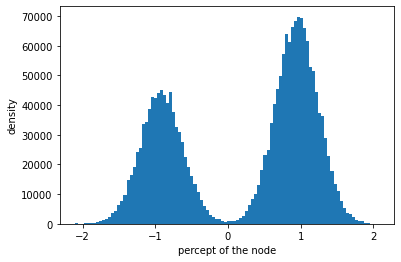

In [8]:
def hist(arr,bins):
    plt.hist(arr,bins)
    return 'plotted'

hist(neuron_1,100)
plt.xlabel('percept of the node')
plt.ylabel('density')

In [18]:
state_num_cont_1 = np.array([len(np.where(state>0)[0]) for state in state_list_cont_1])
print(state_num_cont_1[1:10])
domi_list_cont_1, percept_list_cont_1 = domi_period_count(state_num_cont_1[:200000])

[9 9 9 9 9 9 9 9 9]


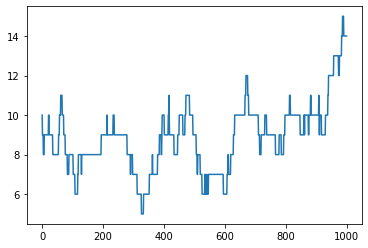

In [13]:
plt.plot(state_num_cont_1[1000:2000])

In [33]:
def trans_pref(domi_list,percept_list):
    #construct a new array, for each sample, element = 1 if in percept 1, 0 if in percept 2
    percept = []
    for i in range(len(domi_list)):
        if percept_list[i] == 1:
            percept = percept+int(domi_list[i])*[1]
        else:
            percept = percept+int(domi_list[i])*[0]
    trans_pref = []
    for i in range(len(percept)):
        trans_pref.append(sum(percept[:i])/(i+1))
    return np.array(trans_pref)

In [28]:
pref=trans_pref(domi_list_cont_1,percept_list_cont_1)

done
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000


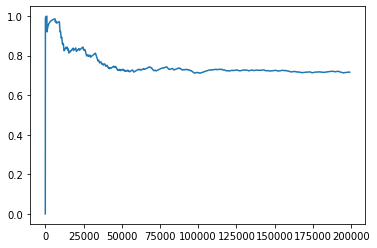

In [30]:
plt.plot(pref)

In [55]:
pref = []
z_ini = (np.random.rand(4,4)-0.75)*2
print(z_ini)
for i in range(50):
    state_list_cont_1= []
    #define initial z
    z = z_ini.copy()
    for i in range(int(1.2e5)):
        z_star = proposal_function(z)
        acc = sample_rejection_cont(z,z_star,mu = np.ones((5,5)))
        if acc:
            z = z_star
        state_list_cont_1.append(z)
    state_num_cont_1 = np.array([len(np.where(state>0)[0]) for state in state_list_cont_1])
    domi_list_cont_1, percept_list_cont_1 = domi_period_count(state_num_cont_1)
    pref_i=trans_pref(domi_list_cont_1,percept_list_cont_1)
    pref.append(pref_i)
    print('done')

[[-1.36954675  0.28258732  0.31554284 -1.43520502]
 [-0.94707578 -0.26914997 -1.35627662 -1.1503698 ]
 [-0.97450205  0.29222448 -0.65978202 -0.79963754]
 [-0.28436849 -0.73278369 -1.34320792 -0.31065269]]
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


In [59]:
pref_unbias = []
z_ini = (np.random.rand(4,4)-0.75)*2
for i in range(20):
    state_list_cont_1= []
    #define initial z
    z = z_ini.copy()
    for i in range(int(1.2e5)):
        z_star = proposal_function(z)
        acc = sample_rejection_cont(z,z_star,mu = np.zeros((5,5)))
        if acc:
            z = z_star
        state_list_cont_1.append(z)
    state_num_cont_1 = np.array([len(np.where(state>0)[0]) for state in state_list_cont_1])
    domi_list_cont_1, percept_list_cont_1 = domi_period_count(state_num_cont_1)
    pref_i=trans_pref(domi_list_cont_1,percept_list_cont_1)
    pref_unbias.append(pref_i)
    print('done')

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


Text(0, 0.5, 'Transient preference')

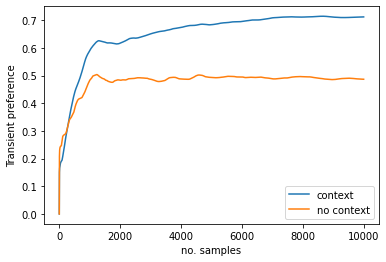

In [62]:
pref = [pref_i[:100000] for pref_i in pref]
pref_ave = np.mean(np.array(pref),axis=0)
plt.plot(pref_ave[:10000])
pref_unbias = [pref_i[:100000] for pref_i in pref_unbias]
pref_ave_unbias = np.mean(np.array(pref_unbias),axis=0)
plt.plot(pref_ave_unbias[:10000])
plt.legend(['context','no context'])
plt.xlabel('no. samples')
plt.ylabel('Transient preference')

In [67]:
z_ini = (np.random.rand(4,4)-0.5)*2
state_list_cont_1_long = []
#define initial z
z = z_ini.copy()
for i in range(int(2e6)):
    z_star = proposal_function(z)
    acc = sample_rejection_cont(z,z_star,mu = np.ones((5,5)))
    if acc:
        z = z_star
    state_list_cont_1_long.append(z)

done


In [90]:
z_ini = (np.random.rand(4,4)-0.5)*2
state_list_cont_unbias_long = []
#define initial z
z = z_ini.copy()
for i in range(int(2e6)):
    z_star = proposal_function(z)
    acc = sample_rejection_cont(z,z_star,mu = np.zeros((5,5)))
    if acc:
        z = z_star
    state_list_cont_unbias_long.append(z)

In [79]:
state_num_cont_1_long = np.array([len(np.where(state>0)[0]) for state in state_list_cont_1_long])
domi_list_cont_1_long, percept_list_cont_1_long = domi_period_count(state_num_cont_1_long)
domi_list_cont_1_long = np.sort(domi_list_cont_1_long)[:-60]
print('done')

done


In [91]:
state_num_cont_unbias_long = np.array([len(np.where(state>0)[0]) for state in state_list_cont_unbias_long])
domi_list_cont_unbias_long, percept_list_cont_unbias_long = domi_period_count(state_num_cont_unbias_long)
domi_list_cont_unbias_long = np.sort(domi_list_cont_unbias_long)[:-60]
print('done')

done


'plotted'

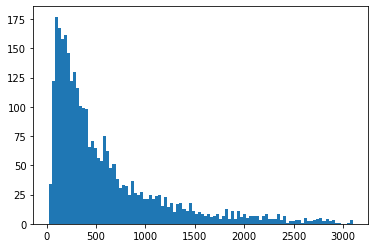

In [80]:
hist(domi_list_cont_1_long,100)

In [87]:
from scipy.optimize import curve_fit

def gamma(x,a,b,c):
    return c*np.exp(-b*x)*x**(a-1)

def gamma_fit_plot(domi_period,n,n_cut=50):
    domi_period = np.sort(domi_period)
    domi_period = domi_period[:-n_cut]
    y,bins=np.histogram(domi_period,n)
    x = []
    for i in range(1,int(n+1)):
        x.append((bins[i]+bins[i-1])/2)
    x=np.array(x)
    popt,pcov = curve_fit(gamma,x/1000,y)
    plt.plot(x/1000,gamma(x/1000,popt[0],popt[1],popt[2]))
    plt.hist(domi_period/1000,int(n+1))
    plt.xlabel('dominance duration')
    plt.ylabel('density')
    plt.legend(['fitted','histogram'])
    return popt

Text(0.5, 1.0, 'with context')

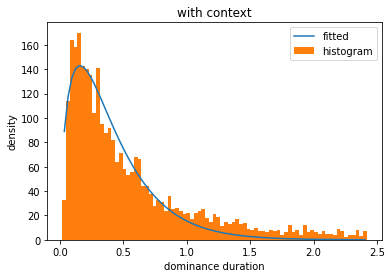

In [97]:
gamma_fit_plot(domi_list_cont_1_long,80,n_cut=50)
plt.title('with context')

Text(0.5, 1.0, 'no context')

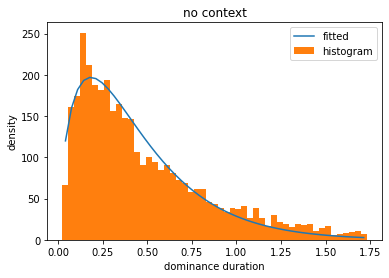

In [98]:
gamma_fit_plot(domi_list_cont_unbias_long,50,n_cut=50)
plt.title('no context')